In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pickle

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "count_highwind", "type_rural", "type_urban"], axis=1)

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [11]:
sorted(set(stations_original))[35]

10081

In [6]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [14]:
model_180 = FetchModel("zip_miss").compile()

In [15]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "nmonths" : 7,
    "month" : months_obs,
    "month_miss" : months_miss
}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180 = az.from_cmdstanpy(fit_180)

22:31:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:40:10 - cmdstanpy - INFO - CmdStan done processing.
22:40:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, 

In [8]:
with open("model_180.pkl", "wb") as f:
    pickle.dump({'model' : model_180, 'fit' : fit_180}, f, protocol=-1)    

In [10]:
post_pred = PostPred(posterior_180, Y['Count_180'])
Y_data = post_pred.Y

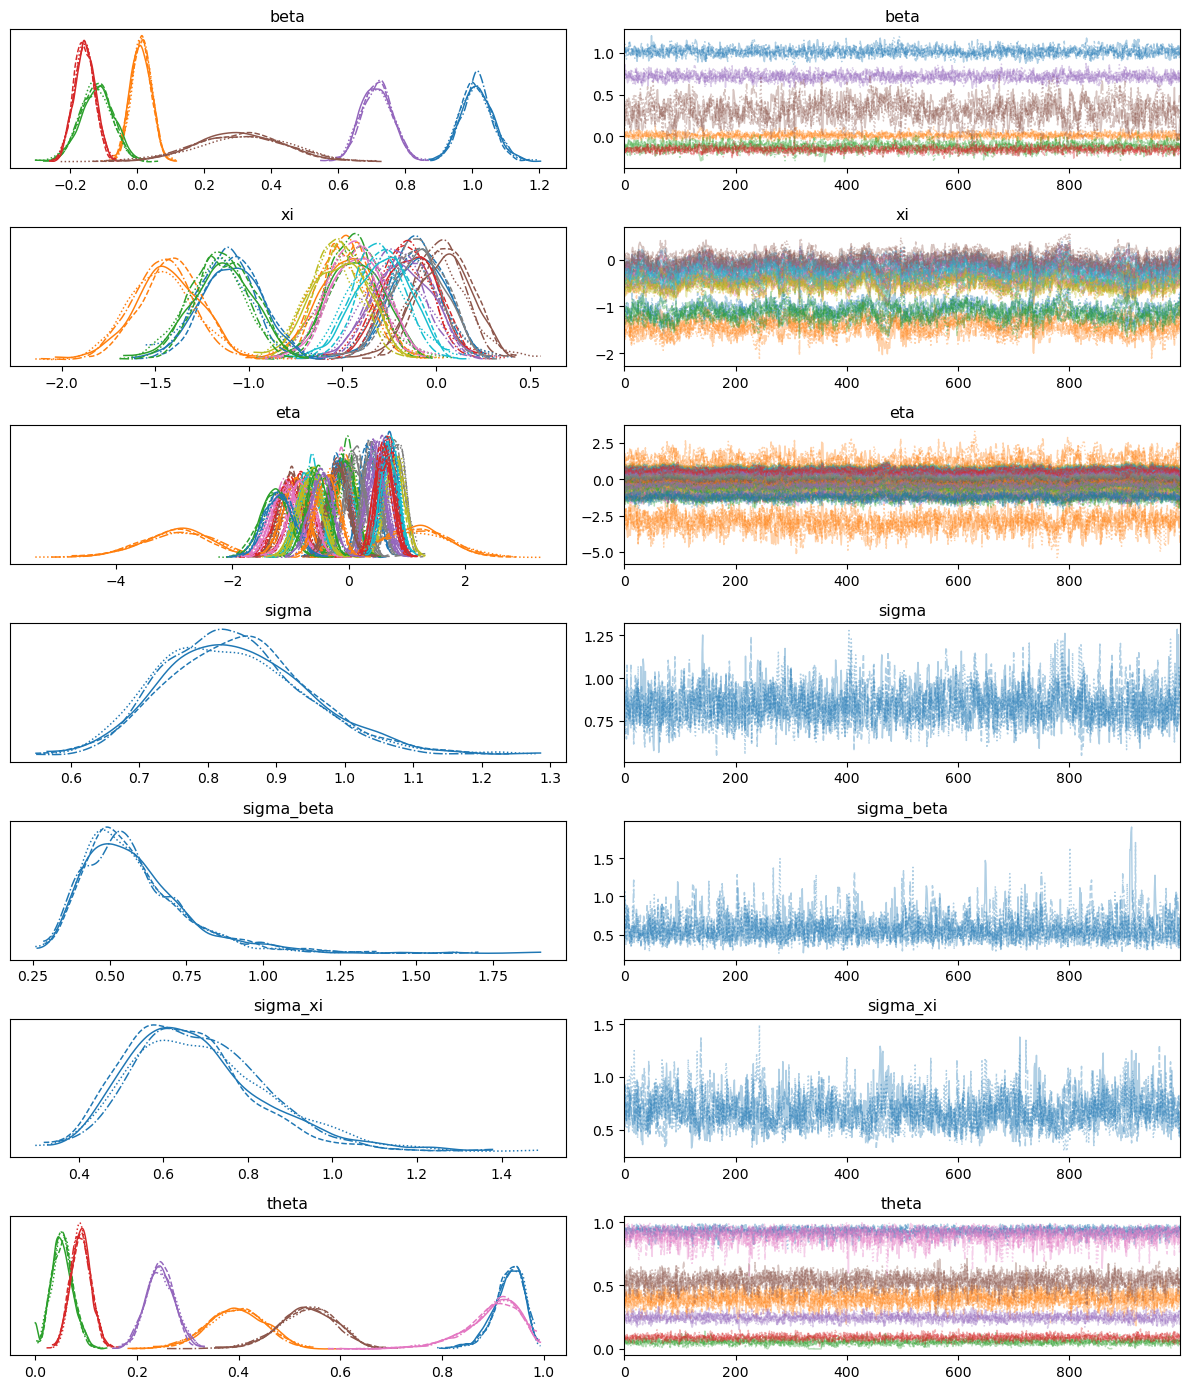

In [18]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi','theta'])
plt.tight_layout()
plt.show()

In [18]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3712.28    78.27
p_waic       96.07        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3712.88    78.30
p_loo       96.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          5    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [12]:
alpha = 0.05
y_pred, metrics = post_pred.predict(error_metrics=True)

In [13]:
y_pred_temp = post_pred.posterior.y_pred.stack(sample=("chain", "draw"))
y_pred_temp_miss = post_pred.posterior.y_pred_miss.stack(sample=("chain", "draw"))

pred_list_obs = [[] for i in range(0,len(idx_obs))]
idx_temp = np.where(post_pred.posterior.y_pred > 0)
for i in range(0,len(idx_obs)):
    pred_list_obs[i].append(y_pred_temp[i].values[np.where(y_pred_temp[i].values > 0)])

pred_list_miss = [[] for i in range(0,len(idx_miss))]
idx_temp = np.where(post_pred.posterior.y_pred_miss > 0)
for i in range(0,len(idx_miss)):
    pred_list_miss[i].append(y_pred_temp_miss[i].values[np.where(y_pred_temp_miss[i].values > 0)]) #Non manca un miss?

pred_list_obs = pd.Series(pred_list_obs, index=idx_obs)
pred_list_miss = pd.Series(pred_list_miss, index=idx_miss)

pred_list = pd.concat([pred_list_obs, pred_list_miss]).sort_index()

pred_list_obs = pred_list_obs.reset_index(drop=True)
pred_list_miss = pred_list_miss.reset_index(drop=True)

In [14]:
alpha = 0.05
theta_med = post_pred.posterior_med.theta.values
alpha_adj = (alpha+theta_med-alpha*theta_med)
y_star_low_obs = []
y_star_up_obs = []
for k in range(0, len(idx_obs)):
    if len(pred_list_obs[k][0]) == 0:
        y_star_low_obs.append(0)
        y_star_up_obs.append(0)
    else:
        y_star_low_obs.append(np.quantile(pred_list_obs[k][0], alpha_adj[months_obs[k]-1]/2))
        y_star_up_obs.append(np.quantile(pred_list_obs[k][0], 1-alpha_adj[months_obs[k]-1]/2))

y_star_low_miss = []
y_star_up_miss = []
for k in range(0, len(idx_miss)):
    if len(pred_list_miss[k][0]) == 0:
        y_star_low_miss.append(0)
        y_star_up_miss.append(0)
    else:
        y_star_low_miss.append(np.quantile(pred_list_miss[k][0], alpha_adj[months_miss[k]-1]/2))
        y_star_up_miss.append(np.quantile(pred_list_miss[k][0], 1-alpha_adj[months_miss[k]-1]/2))

y_star_up_obs = pd.Series(y_star_up_obs, index=idx_obs)
y_star_low_obs = pd.Series(y_star_low_obs, index=idx_obs)
y_star_up_miss = pd.Series(y_star_up_miss, index=idx_miss)
y_star_low_miss = pd.Series(y_star_low_miss, index=idx_miss)

y_star_up = pd.concat([y_star_up_obs, y_star_up_miss]).sort_index()
y_star_low = pd.concat([y_star_low_obs, y_star_low_miss]).sort_index()

y_star_up_obs = y_star_up_obs.reset_index(drop=True)
y_star_low_obs = y_star_low_obs.reset_index(drop=True)
y_star_up_miss = y_star_up_miss.reset_index(drop=True)  
y_star_low_miss = y_star_low_miss.reset_index(drop=True)


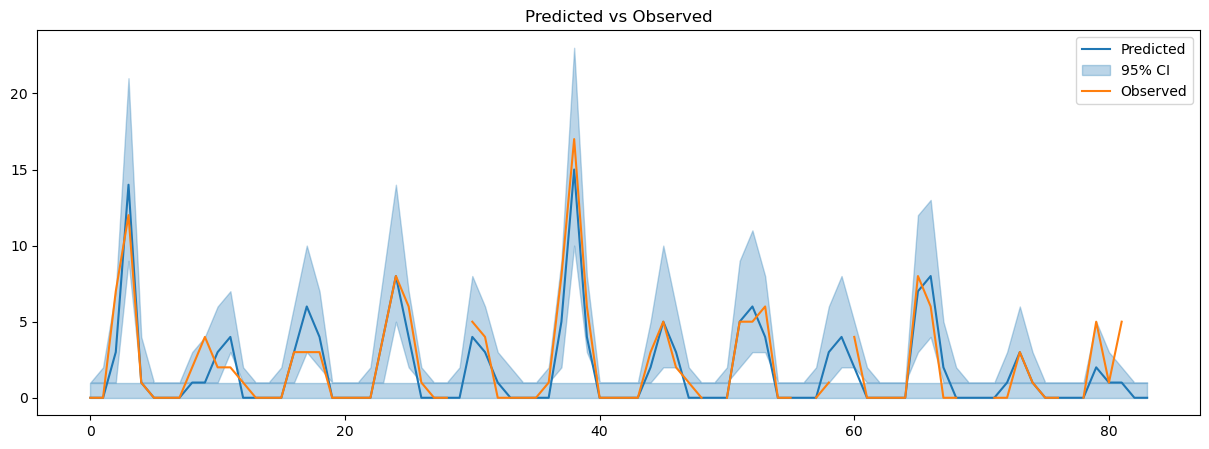

In [15]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', color = 'C0')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], color = 'C0', alpha=0.3, label=f'95% CI')
plt.fill_between(xx, np.zeros(len(xx)), np.zeros(len(xx))+1,color = 'C0', alpha=0.3)
plt.plot(xx, Y_data[xx], label='Observed', color = 'C1')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [16]:
outliers = np.where(((Y['Count_180'][idx_obs] < y_star_low[idx_obs]) | (Y['Count_180'][idx_obs] > y_star_up[idx_obs])) & Y['Count_180'][idx_obs]!=0)[0]
percentage_inside_CI = 1-len(outliers)/len(idx_obs)

In [17]:
y_obs, residuals, mse, mae, mad = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside_CI}\n')

Outliers:
[  11   74   78   85   94  100  150  155  160  176  187  193  233  280
  345  346  347  364  365  366  372  378  384  402  403  441  474  475
  529  579  602  608  644  650  656  657  658  675  676  677  698  710
  729  798  851  867  872  873  875 1014 1036 1043 1093 1094 1122 1142
 1156 1157 1183 1262 1279 1337 1353 1366 1380 1393 1447 1448 1455 1524
 1529 1531 1539 1560 1568 1582 1588 1618 1632 1647 1658 1702 1748 1807
 1813 1821 1832 1878 1879 1923 1928 1935 1973 1983 2095 2102 2110 2127
 2135 2139 2179 2224 2240 2330 2331 2338 2350 2357 2371 2377 2389 2440
 2492 2512 2518 2532 2561 2562 2569 2588 2602 2646 2649 2650 2672 2693
 2705 2750 2757 2769 2851 2877 2879 2905 2940 2987 3018 3030 3044 3087
 3100 3160 3163 3185 3220 3222 3227 3329 3330 3335 3355 3361 3380 3387
 3392 3401 3443 3486 3507 3527 3560 3610 3613 3626 3663 3683 3688 3700
 3711 3723 3725 3743 3770]

The total number of outliers is: 173

The MSE is: 2.177389705882353

The MAE is: 0.7179621848739496

The MAD i

# Final model for 120 dataset

In [2]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(['max_consecutive_highwind_days', 'Densità', 'type_rural', 'type_urban', 'Quota'], axis =1)

In [3]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [7]:
model_120 = FetchModel("space_dummy_rej").compile()

13:06:28 - cmdstanpy - INFO - compiling stan file C:\Users\39339\OneDrive\Desktop\ISEMES~1\BAYESI~2\main\Modello\stan\space_dummy_rej.stan to exe file C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe
13:07:22 - cmdstanpy - INFO - compiled model executable: C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe


In [1]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_120 = az.from_cmdstanpy(fit_120)

NameError: name 'Y_obs' is not defined

In [13]:
with open("model_120.pkl", "wb") as f:
    pickle.dump({'model' : model_120, 'fit' : fit_120}, f, protocol=-1)

In [9]:
post_pred = PostPred(posterior_120, Y['Count_120'])
Y_data = post_pred.Y

In [16]:
# post_pred.posterior.eta.median(dim = ["chain","draw"])

<xarray.DataArray 'eta' (eta_dim_0: 45)>
array([1.96121 , 1.591435, 1.58659 , 1.557275, 1.94337 , 1.63637 ,
       1.304795, 2.12493 , 1.495165, 1.446165, 1.78887 , 1.09565 ,
       1.298005, 2.01696 , 1.960915, 1.473965, 1.74495 , 1.48894 ,
       2.0947  , 1.497165, 1.578075, 1.524735, 1.870495, 1.48171 ,
       1.973875, 1.599035, 1.22108 , 1.809575, 1.60545 , 1.47392 ,
       2.042855, 3.19748 , 1.322965, 1.883575, 1.9875  , 1.81846 ,
       1.58198 , 1.73045 , 1.458175, 2.01249 , 1.180645, 1.65058 ,
       1.697135, 1.84476 , 1.63395 ])
Coordinates:
  * eta_dim_0  (eta_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44

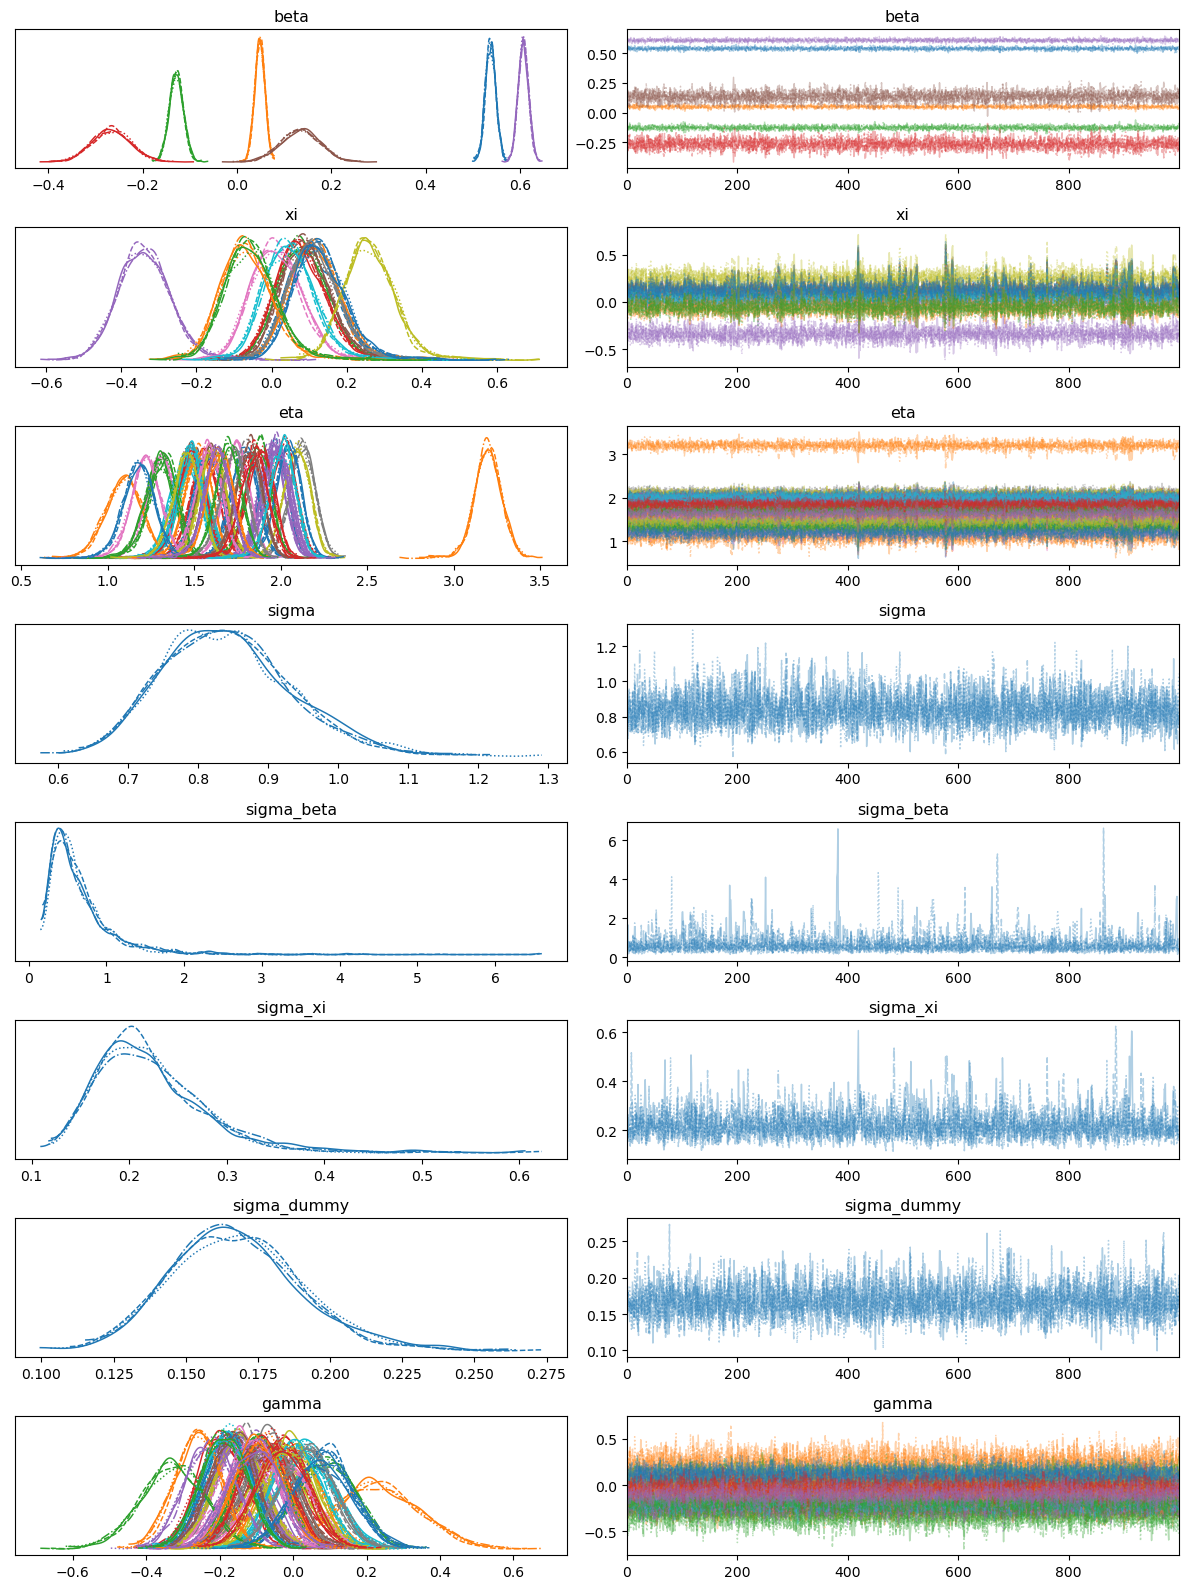

In [10]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi', 'sigma_dummy', 'gamma'])
plt.tight_layout()
plt.show()

In [13]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10055.21    86.32
p_waic      144.85        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10055.88    86.33
p_loo      145.51        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [14]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [15]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   34   83  145  154  165  173  179  227  234  309  350  351  363
  391  394  396  404  410  413  414  420  422  429  430  433  472  478
  479  481  482  486  488  493  512  513  519  581  582  585  588  599
  609  618  648  650  662  665  669  680  682  685  690  695  701  718
  753  757  769  770  771  774  775  781  787  799  802  807  824  835
  842  863  864  869  874  876  877  884  898  901  917  918  919  920
  921  931  950  955  962  984 1016 1019 1021 1022 1026 1032 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1329
 1331 1341 1371 1384 1385 1407 1408 1449 1457 1527 1535 1540 1552 1611
 1631 1667 1765 1774 1786 1824 1848 1859 1867 1869 1874 1880 1889 1897
 1903 1912 1923 1953 1955 1960 1978 1983 1989 2008 2026 2029 2050 2075
 2076 2089 2110 2115 2119 2127 2134 2137 2140 2144 2180 2198 2221 2227
 2234 2238 2241 2251 2274 2291 2301 2315 2327 2332 2363 2367 2375 2382
 2398 2399 2406 2430 2458 2460 2462 2464 2465 2503 2546 2574 2583 2

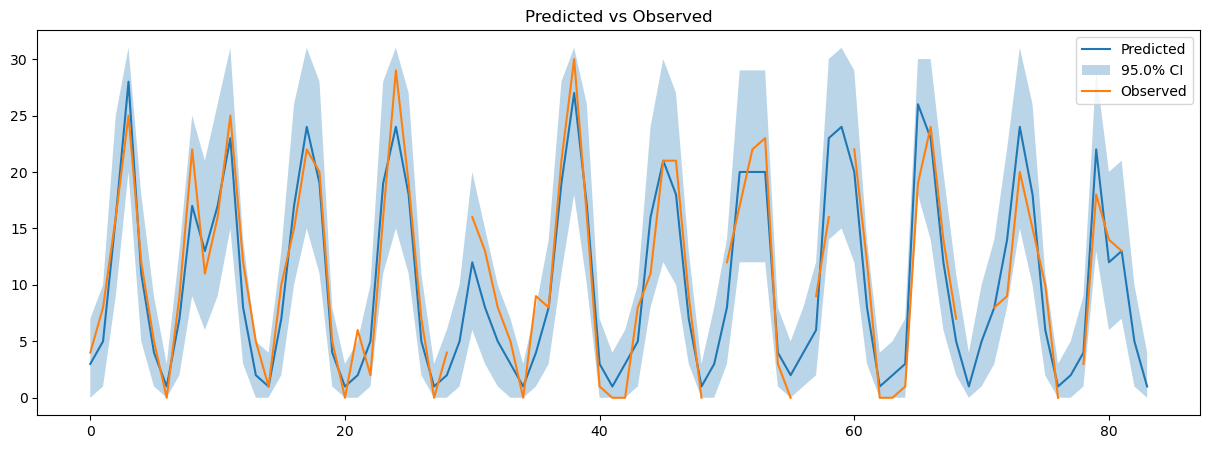

In [16]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()